## LB
More clipping d10m20; tuned num_leaves & min_child_samples for LGB on the last 15 months of data.



In [6]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection

from sklearn.linear_model import LinearRegression, LassoCV
# from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import pickle

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

In [3]:
to_drop = ['shop_id','item_id','date_block_num','shop_item_cnt']

In [4]:
val_month = list(range(28,34))
val_month

[28, 29, 30, 31, 32, 33]

In [38]:
window = 12

### Linear model

In [5]:
monthly_sales_all = pd.read_hdf(r'../data2/lm_feat_ex_1st_12_month.h5','monthly_sales_all')
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(28781280, 51)


,date_block_num,item_id,shop_id,cat_cnt_lag_1,cat_mix_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,shop_item_cnt_lag_1,sys_cnt_lag_1,cat_cnt_lag_2,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,shop_item_cnt
0,12,22154,59,0.275278,0.023307,0.000104,0.153649,0.0,0.253001,0.205060,...,0,0,0,0,0,0,0,0,0,0.0
1,13,22154,59,0.207926,0.019834,0.000000,0.096111,0.0,0.187877,0.275278,...,0,0,0,0,0,0,0,0,0,0.0
2,14,22154,59,0.166561,0.022149,0.000000,0.091497,0.0,0.152736,0.207926,...,0,0,0,0,0,0,0,0,0,0.0


In [6]:
y_test_all = monthly_sales_all.loc[monthly_sales_all.date_block_num>=val_month[0],'shop_item_cnt']
print(y_test_all.shape)
y_test_all[:3]

(13082400,)


12    0.0
13    0.0
14    0.0
Name: shop_item_cnt, dtype: float32

In [7]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lm_pred = np.zeros(y_test_all.shape,dtype=np.float32)
lm_pred.shape

(13082400,)

In [9]:
res_pos=0
for m in tqdm_notebook(val_month):
    end = m
    start = end -12

    val = monthly_sales_all.loc[monthly_sales_all.date_block_num == end]

    X_train = monthly_sales_all[(monthly_sales_all.date_block_num<end) & (monthly_sales_all.date_block_num>=start)].drop(labels=to_drop,axis=1)
    y_train = monthly_sales_all.loc[(monthly_sales_all.date_block_num<end) & (monthly_sales_all.date_block_num>=start),'shop_item_cnt']

    gc.collect()

    lm.fit(X_train,y_train)

    lm_pred[res_pos:(res_pos+len(val))] = lm.predict(val.drop(labels=to_drop,axis=1))
    
    res_pos += len(val)

In [10]:
rmse_clip(y_test_all,lm_pred)

1.7558638558845077

In [11]:
np.save(r'../data2/lm_pred.np5',lm_pred)

In [13]:
pickle.dump(lm, open(r'../data2/lm_model.sav',"wb"))

### LGB

In [7]:
monthly_sales_all = pd.read_hdf(r'../data2/tree_feats_ex_1st_12month.h5','monthly_sales_all')
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num<34]
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(28781280, 59)


,date_block_num,item_id,shop_id,cat_cnt_lag_1,cat_mix_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,shop_item_cnt_lag_1,sys_cnt_lag_1,cat_cnt_lag_2,...,cat_ma1,cat_ma2,cat_ma3,cat_mix_ma1,cat_mix_ma2,cat_mix_ma3,sys_ma1,sys_ma2,sys_ma3,shop_item_cnt
0,12,22154,59,0.275985,0.029204,0.000137,0.157059,0.0,0.267969,0.205587,...,0.224890,0.203837,0.215818,0.024193,0.030824,0.031341,0.216352,0.192659,0.201874,0.0
1,13,22154,59,0.208460,0.024852,0.000000,0.098367,0.0,0.198992,0.275985,...,0.230010,0.224890,0.203837,0.024707,0.024193,0.030824,0.221556,0.216352,0.192659,0.0
2,14,22154,59,0.166989,0.027753,0.000000,0.093580,0.0,0.161772,0.208460,...,0.217145,0.230010,0.224890,0.027270,0.024707,0.024193,0.209577,0.221556,0.216352,0.0


In [8]:
y_test_all = monthly_sales_all.loc[monthly_sales_all.date_block_num>=val_month[0],'shop_item_cnt']
print(y_test_all.shape)
y_test_all[:3]

(7849440,)


16    0.0
17    0.0
18    0.0
Name: shop_item_cnt, dtype: float32

In [13]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.03,
                              num_leaves=64,     # tuned
                              max_depth=7,
                              min_child_samples=2**7,  # tuned
                              subsample=0.75,
                              subsample_freq=1,
                              colsample_bytree=0.75,
                              objective='mse',
                              random_state=2**7,
                              n_jobs=6)
lgb_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
       importance_type='split', learning_rate=0.03, max_depth=7,
       min_child_samples=128, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=6, num_leaves=64, objective='mse',
       random_state=128, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.75, subsample_for_bin=200000, subsample_freq=1)

In [14]:
lgb_pred = np.zeros(y_test_all.shape,dtype=np.float32)
lgb_pred.shape

(7849440,)

In [18]:
gc.collect()

0

In [19]:
res_pos=0
for m in tqdm_notebook(val_month):
    end = m
    start = end - window

    val = monthly_sales_all.loc[monthly_sales_all.date_block_num == end]

    X_train = monthly_sales_all[(monthly_sales_all.date_block_num<end) & (monthly_sales_all.date_block_num>=start)].drop(labels=to_drop,axis=1)
    y_train = monthly_sales_all.loc[(monthly_sales_all.date_block_num<end) & (monthly_sales_all.date_block_num>=start),'shop_item_cnt']

    gc.collect()

    lgb_model.fit(X_train, y_train)

    lgb_pred[res_pos:(res_pos+len(val))] = lgb_model.predict(val.drop(labels=to_drop,axis=1))
    
    res_pos += len(val)

In [20]:
np.save(r'../lgb_result_clip_d10m20_15m.np5',lgb_pred)

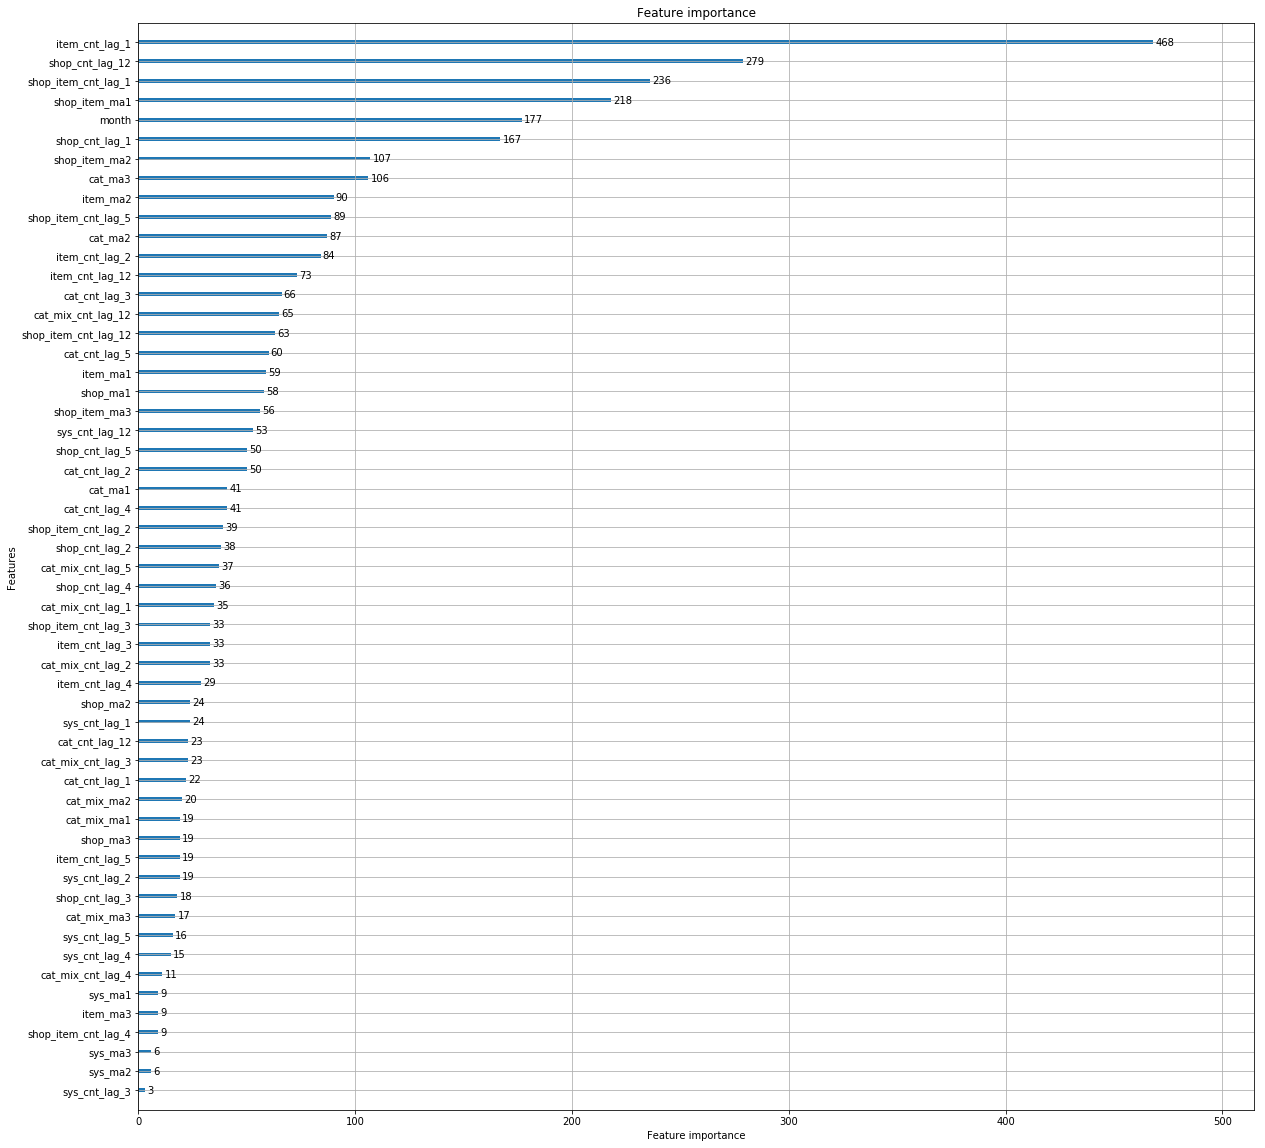

In [23]:
lgb.plot_importance(lgb_model,figsize=(20,20))

In [25]:
rmse_clip(y_test_all[y_test_all<20],lgb_pred[y_test_all<20])

0.4989820489311084

In [27]:
pickle.dump(lgb_model,open('../data2/lgb_model_clip_d10m20_15m.sav','wb'))

### Train 2nd level model

In [34]:
lm_pred = np.load(r'../data2/lm_pred.np5.npy')
lm_pred

array([-0.02670222,  0.00490824,  0.00501765, ...,  0.01472729,
        0.01472729,  0.01472729], dtype=float32)

In [35]:
lgb_pred = np.load(r'../data2/lgb_result.np5.npy')
lgb_pred

array([0.0264474 , 0.01297819, 0.01297819, ..., 0.01061339, 0.01061339,
       0.01061339], dtype=float32)

In [36]:
meta_X = np.vstack((lm_pred,lgb_pred)).T

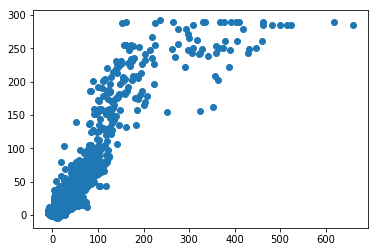

In [102]:
plt.scatter(meta_X[:,0],meta_X[:,1])

In [103]:
meta_X2 = meta_X[y_test_all>0]

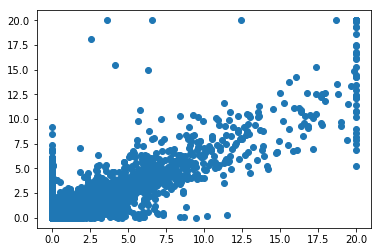

In [106]:
plt.scatter(meta_X2[:,0].clip(0,20),meta_X2[:,1].clip(0,20))

In [132]:
lm_2nd = RandomForestRegressor()
lm_2nd

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
lm_2nd.fit(meta_X,y_test_all)
y_pred = lm_2nd.predict(meta_X)

In [140]:
rmse_clip(y_true=y_test_all[y_test_all>0],y_pred=y_pred[y_test_all>0])

9.4691886605645

In [141]:
pd.Series(y_pred).describe()

count    353652.000000
mean          2.171098
std           6.356158
min           1.000000
25%           1.100000
50%           1.500000
75%           2.100000
max        1127.300000
dtype: float64

### Create a new submission

In [9]:
lm = np.load(r'../data2/lm_model.sav')
model = np.load(r'../data2/lgb_model.sav')

##### Fit 1st level LGB

In [28]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/tree_feats_ex_1st_12month.h5','monthly_sales_all')

Wall time: 44.2 s


In [29]:
monthly_sales_all.date_block_num.max()

34

In [30]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num==34]

In [31]:
lgb_test_pred = lgb_model.predict(monthly_sales_all.drop(labels=to_drop,axis=1))

##### Fit 1st level lm

In [24]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/lm_feat_ex_1st_12_month.h5','monthly_sales_all')

Wall time: 42.5 s


In [25]:
monthly_sales_all.date_block_num.max()

34

In [26]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num==34]

In [27]:
lm_test_pred = lm.predict(monthly_sales_all.drop(labels=to_drop,axis=1))

##### Fit 2nd level model

In [32]:
# pred = lm_2nd.predict(np.vstack((lm_test_pred.clip(0,20), lgb_test_pred.clip(0,20))).T)
pred = lgb_test_pred

In [33]:
monthly_sales_all['item_cnt_month'] = pred.clip(0,20)

In [34]:
monthly_sales_all['item_cnt_month'].describe()

count    1.308240e+06
mean     5.028273e-02
std      3.122791e-01
min      0.000000e+00
25%      1.187409e-02
50%      1.538297e-02
75%      2.055449e-02
max      2.000000e+01
Name: item_cnt_month, dtype: float64

#### Read in test data and get features

In [35]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [36]:
test2 = pd.merge(test,monthly_sales_all,on=['shop_id','item_id'],how='left').fillna(0)
print(test2.shape)
test2[:3]

(214200, 61)


,ID,shop_id,item_id,date_block_num,cat_cnt_lag_1,cat_mix_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,shop_item_cnt_lag_1,sys_cnt_lag_1,...,cat_ma2,cat_ma3,cat_mix_ma1,cat_mix_ma2,cat_mix_ma3,sys_ma1,sys_ma2,sys_ma3,shop_item_cnt,item_cnt_month
0,0,5,5037,34.0,0.067691,0.031578,0.003435,0.069119,0.00,0.05615,...,0.108471,0.104594,0.043338,0.047699,0.051516,0.083794,0.089573,0.086735,0.0,0.474392
1,1,5,5320,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2,5,5233,34.0,0.067691,0.076374,0.005771,0.069119,0.05,0.05615,...,0.108471,0.104594,0.118085,0.122788,0.114342,0.083794,0.089573,0.086735,0.0,0.845674


In [37]:
test2[['ID','item_cnt_month']].to_csv(r'../output/21_1023_lgb_clip_d10m20_15month.csv',index=False)